In [1]:
import numpy as np

from time import time

import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

In [2]:
num_sites = 3
for i in range(num_sites):
    print(i)

0
1
2


In [3]:
import retworkx as rx

from qiskit_nature.problems.second_quantization.lattice import Lattice

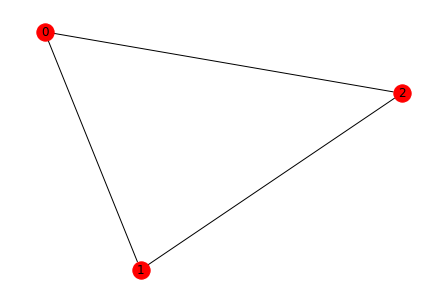

In [4]:
# Kagome unit cell
num_sites = 3
# Edge weight
t = 1.0

# Generate graph of kagome unit cell
# Start by defining all the edges
graph = rx.PyGraph(multigraph=False)
graph.add_nodes_from(range(num_sites))
edge_list = [
    (0, 1, t),
    (1, 2, t),
    (2, 0, t)]

# Generate graph from the list of edges
graph.add_edges_from(edge_list)

# Make a Lattice from graph
kagome_unit_cell = Lattice(graph)

# Draw Lattice
kagome_unit_cell.draw(style={'node_color':'red', 'with_labels':True})
# plt.savefig('kagome_unit_cell.png')
plt.show()

In [5]:
# Custom Heisenberg couplings
from heisenberg_model import HeisenbergModel

In [6]:
from qiskit_nature.mappers.second_quantization import LogarithmicMapper

In [7]:
# Build Hamiltonian from graph edges
heis = HeisenbergModel.uniform_parameters(
    lattice=kagome_unit_cell,
    uniform_interaction=1.0,  # same spin-spin interaction weight as used in graph
    uniform_onsite_potential=0.0,  # No single site external field
)

print(heis.second_q_ops().simplify())

  Z_1 Z_2 * (1+0j)
+ Z_0 Z_2 * (1+0j)
+ Z_0 Z_1 * (1+0j)
+ Y_1 Y_2 * (1+0j)
+ Y_0 Y_2 * (1+0j)
+ Y_0 Y_1 * (1+0j)
+ X_1 X_2 * (1+0j)
+ X_0 X_2 * (1+0j)
+ X_0 X_1 * (1+0j)


In [8]:
# The Lattice needs an explicit mapping to the qubit states.
# We map 1 qubit for 1 spin-1/2 particle using the LogarithmicMapper
log_mapper = LogarithmicMapper()
# Multiply by factor of 4 to account for (1/2)^2 terms from spin operators in the HeisenbergModel
ham = 4*log_mapper.map(heis.second_q_ops().simplify())
# Print Hamiltonian to check it's what we expect.
# There are 18 edges and 3 terms per edge (XX, YY, and ZZ),
# so there should be 54 equally weighted terms.
ham

PauliSumOp(SparsePauliOp(['ZZI', 'ZIZ', 'IZZ', 'YYI', 'YIY', 'IYY', 'XXI', 'XIX', 'IXX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j]), coeff=1)

In [9]:
from qiskit.algorithms import NumPyEigensolver

# find the first three (k=3) eigenvalues
exact_solver = NumPyEigensolver(k=3)
exact_result = exact_solver.compute_eigenvalues(ham)
print(exact_result.eigenvalues)

[-3. -3. -3.]


In [10]:
# Save ground state energy for later
gs_energy = np.round(exact_result.eigenvalues[0], 4)
print(gs_energy)

-3.0


In [11]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter

from qiskit import IBMQ

In [12]:
# Doc for loading IBMQ account https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq#the-account

# TOKEN='55e2df6536e204c8a32fde954a4936945598573d6bbc08eeb38f2479e791aa66bea18252ca378bf445189a9d6deace7c734c7703753c9540ab663ad7ff16a299'
# IBMQ.save_account(TOKEN)

provider = IBMQ.load_account()

In [13]:
# IBMQ.providers()
# provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

# Real backend; needed for transpilation later on
# guadalupe = provider.get_backend("ibmq_guadalupe")

# Get fake backend if you like
from qiskit.providers.fake_provider import FakeGuadalupeV2

# Noisy simulator backend
noisy_sim = FakeGuadalupeV2()

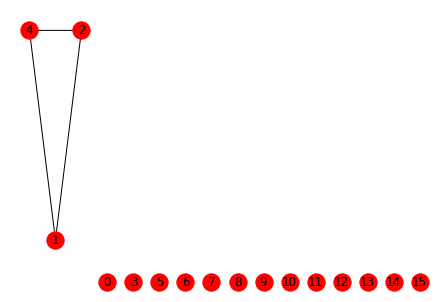

In [14]:
# Kagome unit cell
num_qubits = 16
# Edge weight
t = 1.0

# Generate graph of kagome unit cell
# Start by defining all the edges
graph_16 = rx.PyGraph(multigraph=False)
graph_16.add_nodes_from(range(num_qubits))
edge_list = [
    (1, 2, t),
    (2, 4, t),
    (4, 1, t)]

# Generate graph from the list of edges
graph_16.add_edges_from(edge_list)

# Make a Lattice from graph
kagome_unit_cell_16 = Lattice(graph_16)

# Draw Lattice
kagome_pos = {0:[1,-1.2], 3:[1.5, -1.2], 5:[2, -1.2], 6:[2.5, -1.2], 7:[3,-1.2], 8:[3.5,-1.2], 9:[4,-1.2], 10:[4.5,-1.2], 11:[5,-1.2], 12:[5.5,-1.2], 13:[6,-1.2], 14:[6.5,-1.2], 15:[7,-1.2],
              1:[0,-1],
              2:[0.5,0], 
              4:[-0.5,0]}
kagome_unit_cell_16.draw(style={'node_color':'red', 'with_labels':True, 'pos':kagome_pos})
# plt.savefig('kagome_unit_cell.png')
plt.show()

In [15]:
# Build Hamiltonian from graph edges
heis_16 = HeisenbergModel.uniform_parameters(
    lattice=kagome_unit_cell_16,
    uniform_interaction=t,
    uniform_onsite_potential=0.0,  # No singe site external field
)

# Map from SpinOp to qubits just as before.
log_mapper = LogarithmicMapper()
ham_16 = 4 * log_mapper.map(heis_16.second_q_ops().simplify())
# Print Hamiltonian to check it's what we expect:
# 9 ZZ, 9 YY, and 9 XX terms over 7 qubits instead of over 6 qubits
ham_16

PauliSumOp(SparsePauliOp(['IIIIIIIIIIIZIZII', 'IIIIIIIIIIIZIIZI', 'IIIIIIIIIIIIIZZI', 'IIIIIIIIIIIYIYII', 'IIIIIIIIIIIYIIYI', 'IIIIIIIIIIIIIYYI', 'IIIIIIIIIIIXIXII', 'IIIIIIIIIIIXIIXI', 'IIIIIIIIIIIIIXXI'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j]), coeff=1)

In [16]:
from qiskit.circuit.library import EfficientSU2

In [17]:
# Construct ansatz from qiskit circuit library functions
# See docs for full details
ansatz = EfficientSU2(3, entanglement='full', reps=4, skip_final_rotation_layer=True).decompose()
ansatz.draw(fold=300)

┌──────────┐┌──────────┐          ┌──────────┐┌──────────┐                       ┌───────────┐┌───────────┐                       ┌───────────┐┌───────────┐                            
q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[3]) ├──■────■──┤ Ry(θ[6]) ├┤ Rz(θ[9]) ├───────────────■────■──┤ Ry(θ[12]) ├┤ Rz(θ[15]) ├───────────────■────■──┤ Ry(θ[18]) ├┤ Rz(θ[21]) ├───────────────■────■───────
     ├──────────┤├──────────┤┌─┴─┐  │  └──────────┘├──────────┤┌───────────┐┌─┴─┐  │  └───────────┘├───────────┤┌───────────┐┌─┴─┐  │  └───────────┘├───────────┤┌───────────┐┌─┴─┐  │       
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[4]) ├┤ X ├──┼───────■──────┤ Ry(θ[7]) ├┤ Rz(θ[10]) ├┤ X ├──┼────────■──────┤ Ry(θ[13]) ├┤ Rz(θ[16]) ├┤ X ├──┼────────■──────┤ Ry(θ[19]) ├┤ Rz(θ[22]) ├┤ X ├──┼────■──
     ├──────────┤├──────────┤└───┘┌─┴─┐   ┌─┴─┐    ├──────────┤├───────────┤└───┘┌─┴─┐    ┌─┴─┐    ├───────────┤├───────────┤└───┘┌─┴─┐    ┌─┴─┐    ├───────────┤├───────────┤└───┘┌─┴─┐┌─┴─┐
q_2: ┤ Ry(θ[2]) ├┤ Rz(θ[5]) ├─────┤ X ├───┤ X ├────┤ Ry(θ[8]) ├┤ Rz(θ[11]) ├─────┤ X ├────┤ X ├────┤ Ry(θ[14]) ├┤ Rz(θ[17]) ├─────┤ X ├────┤ X ├────┤ Ry(θ[20]) ├┤ Rz(θ[23]) ├─────┤ X ├┤ X ├
     └──────────┘└──────────┘     └───┘   └───┘    └──────────┘└───────────┘     └───┘    └───┘    └───────────┘└───────────┘     └───┘    └───┘    └───────────┘└───────────┘     └───┘└───┘

In [18]:
# Build a custom ansatz from scratch
ansatz_custom = QuantumCircuit(3)
# build initial state

ansatz_custom.h(0)
ansatz_custom.h(2)
ansatz_custom.cx(0,1)

# First layer
j = 0
for i in range(3):
    ansatz_custom.rz(Parameter('θ_' + str(j)), i)
    j += 1
    ansatz_custom.ry(Parameter('θ_' + str(j)), i)
    j += 1
    
ansatz_custom.cx(range(0, 2), range(1, 3))

ansatz_custom.draw(fold=250)

┌───┐           ┌─────────┐┌─────────┐          
q_0: ┤ H ├─────■─────┤ Rz(θ_0) ├┤ Ry(θ_1) ├──■───────
     └───┘   ┌─┴─┐   ├─────────┤├─────────┤┌─┴─┐     
q_1: ────────┤ X ├───┤ Rz(θ_2) ├┤ Ry(θ_3) ├┤ X ├──■──
     ┌───┐┌──┴───┴──┐├─────────┤└─────────┘└───┘┌─┴─┐
q_2: ┤ H ├┤ Rz(θ_4) ├┤ Ry(θ_5) ├────────────────┤ X ├
     └───┘└─────────┘└─────────┘                └───┘

In [19]:
q_layout = [1, 2, 4]
ansatz_opt = transpile(ansatz, backend=noisy_sim, initial_layout=q_layout)

In [20]:
print('number and type of gates in the cirucit:', ansatz_opt.count_ops())
print('number of parameters in the circuit:', ansatz_opt.num_parameters)
ansatz_opt.draw(fold=300)

number and type of gates in the cirucit: OrderedDict([('rz', 36), ('cx', 27), ('sx', 24)])
number of parameters in the circuit: 24


»
  ancilla_0 -> 0 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────»
                 ┌────┐┌──────────────┐┌────┐┌────────┐┌──────────┐          ┌────┐┌──────────────┐┌────┐┌────────┐┌──────────┐     ┌───┐          ┌────┐┌──────────────┐┌────┐┌────────┐┌───────────┐┌───┐     ┌───┐     ┌───┐      ┌───┐      ┌────┐     ┌───────────────┐  ┌────┐    ┌────────┐ »
        q_0 -> 1 ┤ √X ├┤ Rz(θ[0] + π) ├┤ √X ├┤ Rz(3π) ├┤ Rz(θ[3]) ├──■────■──┤ √X ├┤ Rz(θ[6] + π) ├┤ √X ├┤ Rz(3π) ├┤ Rz(θ[9]) ├──■──┤ X ├──■────■──┤ √X ├┤ Rz(θ[7] + π) ├┤ √X ├┤ Rz(3π) ├┤ Rz(θ[10]) ├┤ X ├──■──┤ X ├──■──┤ X ├──────┤ X ├──────┤ √X ├─────┤ Rz(θ[14] + π) ├──┤ √X ├────┤ Rz(3π) ├─»
                 ├────┤├──────────────┤├────┤├────────┤├──────────┤┌─┴─┐  │  └────┘└──────────────┘└────┘└────────┘└──────────┘┌─┴─┐└─┬─┘┌─┴─┐  │  └────┘└──────────────┘└────┘└────────┘└───────────┘└─┬─┘  │  └─┬─┘  │  └─┬─┘┌────┐└─┬─┘┌─────┴────┴────┐└─────┬────┬────┘┌─┴────┴─┐┌─┴────────┴┐»
        q_1 -> 2 ┤ √X ├┤ Rz(θ[1] + π) ├┤ √X ├┤ Rz(3π) ├┤ Rz(θ[4]) ├┤ X ├──┼────────────────────────────────────────────────────┤ X ├──■──┤ X ├──┼───────────────────────────────────────────────────────■────┼────┼────┼────■──┤ √X ├──┼──┤ Rz(θ[12] + π) ├──────┤ √X ├─────┤ Rz(3π) ├┤ Rz(θ[15]) ├»
                 └────┘└──────────────┘└────┘└────────┘└──────────┘└───┘  │                                                    └───┘     └───┘  │                                                            │    │    │       └────┘  │  └───────────────┘      └────┘     └────────┘└───────────┘»
  ancilla_1 -> 3 ─────────────────────────────────────────────────────────┼─────────────────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────────┼────┼────┼───────────────┼───────────────────────────────────────────────────────────»
                 ┌────┐┌──────────────┐┌────┐┌────────┐┌──────────┐     ┌─┴─┐                                                                 ┌─┴─┐┌────┐┌──────────────┐┌────┐┌────────┐┌───────────┐     ┌─┴─┐  │  ┌─┴─┐             │        ┌────┐     ┌───────────────┐  ┌────┐    ┌────────┐ »
        q_2 -> 4 ┤ √X ├┤ Rz(θ[2] + π) ├┤ √X ├┤ Rz(3π) ├┤ Rz(θ[5]) ├─────┤ X ├─────────────────────────────────────────────────────────────────┤ X ├┤ √X ├┤ Rz(θ[8] + π) ├┤ √X ├┤ Rz(3π) ├┤ Rz(θ[11]) ├─────┤ X ├──■──┤ X ├─────────────■────────┤ √X ├─────┤ Rz(θ[13] + π) ├──┤ √X ├────┤ Rz(3π) ├─»
                 └────┘└──────────────┘└────┘└────────┘└──────────┘     └───┘                                                                 └───┘└────┘└──────────────┘└────┘└────────┘└───────────┘     └───┘     └───┘                      └────┘     └───────────────┘  └────┘    └────────┘ »
  ancilla_2 -> 5 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────»
                                                                                                                                                                                                                                                                                                   »
  ancilla_3 -> 6 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────»
                                                                                                                                                                                             

In [21]:
from qiskit.algorithms.optimizers import SPSA

optimizer = SPSA(maxiter=200)

In [22]:
from qiskit.algorithms import MinimumEigensolver, VQEResult

# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            # Execute job with estimator primitive
            job = self._estimator.run([self._circuit], [operators], [x])
            # Get results from jobs
            est_result = job.result()
            # Get the measured energy value
            value = est_result.values[0]
            # Save result information using callback function
            if self._callback is not None:
                self._callback(value)
            return value
            
        # Select an initial point for the ansatzs' parameters
        x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

In [23]:
# Define a simple callback function
intermediate_info = []
def callback(value):
        intermediate_info.append(value)

In [24]:
from qiskit_ibm_runtime import (QiskitRuntimeService, Session, Options,
                                Estimator as RuntimeEstimator)
from qiskit import Aer

In [25]:
service = QiskitRuntimeService(channel='ibm_quantum')

In [26]:
# Define a simple callback function
intermediate_info_sim_backend = []
def callback_sim(value):
        intermediate_info_sim_backend.append(value)

In [27]:
from qiskit_aer.noise import NoiseModel

In [28]:
noise_model = NoiseModel.from_backend(noisy_sim)

In [29]:
options = Options(simulator={
    "noise_model": noise_model,
    "seed_simulator": 42,
}, resilience_level=1)

In [30]:
# print available backend and select one
print('Simulators:', service.backends(simulator=True))

# Select a simulator backend
backend = 'ibmq_qasm_simulator'

Simulators: [<IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_statevector')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_stabilizer')>]


In [32]:
# Setup Estimator
start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeEstimator(session=session, options=options)
    # Set up algorithm
    custom_vqe = CustomVQE(rt_estimator, ansatz_opt, optimizer, callback=callback_sim)
    # Run algorithm
    result = custom_vqe.compute_minimum_eigenvalue(ham_16)
end = time()
print(f'execution time (s): {end - start:.2f}')

execution time (s): 6840.47


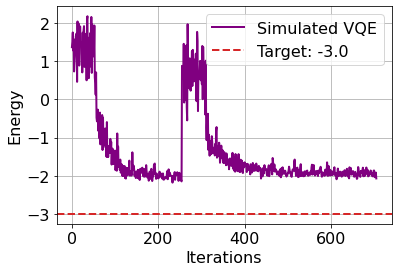

In [33]:
plt.plot(intermediate_info_sim_backend, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

In [36]:
def rel_err(target, measured):
    return abs((target - measured) / target)

In [37]:
# Compute the relative error between the expected ground state energy and the measured
rel_error = rel_err(gs_energy, result.eigenvalue)

print(f'Expected ground state energy: {gs_energy:.10f}')
print(f'Computed ground state energy: {result.eigenvalue:.10f}')
print(f'Relative error: {rel_error:.8f}')

Expected ground state energy: -3.0000000000
Computed ground state energy: -2.0709373564
Relative error: 0.30968755
